In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

lucky_7 = 7

random.seed(lucky_7)
np.random.seed(lucky_7)
warnings.filterwarnings("ignore")

In [2]:
shhs1_dataset_df = pd.read_csv("shhs1-dataset-0.21.0.csv")
odi_df = pd.read_csv("data/shhs/polysomnography/edfs/shhs1/extracted_116_features.csv")

In [3]:
shhs1_dataset_df = shhs1_dataset_df.set_index("nsrrid")
shhs1_dataset_df.head()

,pptid,ecgdate,lvh3_1,lvh3_3,st4_1_3,st5_1_3,lvhst,mob1,part2deg,mob2,...,eoglqual,chinqual,oximqual,posqual,lightoff,oximet51,monitor_id,headbox_id,rcrdtime,psg_month
nsrrid,,,,,,,,,,,,,,,,,,,,,
200001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,96.0,18.0,18.0,7:16:00,6
200002,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,4,4,NaN,94.0,17.0,17.0,9:00:00,1
200003,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,95.0,17.0,17.0,7:10:00,2
200004,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,3,3,0.0,96.0,19.0,19.0,5:58:00,4
200005,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,0.0,96.0,18.0,18.0,7:57:00,3


In [4]:
odi_df.head()

,Unnamed: 0,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,DD100_sd_thr3,...,PRSAc,PRSAad,PRSAos,PRSAsb,PRSAsa,AC,PSD_total,PSD_band,PSD_ratio,PSD_peak
0,200031,5.285714,41.432432,17.283863,238.027027,113.907854,84.513514,48.928310,7.405405,1.218317,...,-0.388284,1.003618,-0.048800,-0.005656,0.026243,111074.190759,0.008547,0.002656,0.310772,0.001170
1,200004,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,0.993808,...,-0.369462,1.012658,-0.029063,0.018169,0.032183,110650.182464,0.004051,0.000922,0.227537,0.000326
2,200005,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,8.350000,1.423903,...,-0.404726,1.006707,-0.044592,0.005684,0.030181,107762.356450,0.007806,0.002634,0.337397,0.000802
3,200003,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,8.088235,1.442376,...,-0.424613,1.009535,-0.053831,0.004544,0.021189,109267.875581,0.008494,0.003076,0.362082,0.000906
4,200002,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,9.437500,1.350636,...,-0.451494,1.689968,-0.106708,-0.055897,-0.042257,105522.715545,0.026928,0.012601,0.467954,0.004824


In [5]:
odi_df = odi_df.set_index(odi_df.columns[0])
odi_df.head()

,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,DD100_sd_thr3,DDmax_u_thr3,...,PRSAc,PRSAad,PRSAos,PRSAsb,PRSAsa,AC,PSD_total,PSD_band,PSD_ratio,PSD_peak
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
200031,5.285714,41.432432,17.283863,238.027027,113.907854,84.513514,48.928310,7.405405,1.218317,3.783784,...,-0.388284,1.003618,-0.048800,-0.005656,0.026243,111074.190759,0.008547,0.002656,0.310772,0.001170
200004,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,0.993808,4.111111,...,-0.369462,1.012658,-0.029063,0.018169,0.032183,110650.182464,0.004051,0.000922,0.227537,0.000326
200005,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,8.350000,1.423903,3.650000,...,-0.404726,1.006707,-0.044592,0.005684,0.030181,107762.356450,0.007806,0.002634,0.337397,0.000802
200003,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,8.088235,1.442376,3.764706,...,-0.424613,1.009535,-0.053831,0.004544,0.021189,109267.875581,0.008494,0.003076,0.362082,0.000906
200002,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,9.437500,1.350636,4.734375,...,-0.451494,1.689968,-0.106708,-0.055897,-0.042257,105522.715545,0.026928,0.012601,0.467954,0.004824


In [6]:
df = shhs1_dataset_df.merge(right=odi_df, how="inner", left_index=True, right_index=True).loc[:, ["age_s1", "gender", "ahi_o0h3"] + odi_df.columns.tolist()]

In [7]:
print(shhs1_dataset_df.shape[0], odi_df.shape[0], df.shape[0])

5804 142 142


In [8]:
df.head()

,age_s1,gender,ahi_o0h3,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,...,PRSAc,PRSAad,PRSAos,PRSAsb,PRSAsa,AC,PSD_total,PSD_band,PSD_ratio,PSD_peak
200001,55,1,4.314248,3.142857,40.318182,22.475009,323.659091,203.137962,90.068182,84.195699,...,-0.338299,0.986975,-0.028169,0.016069,0.024809,103438.680219,0.006747,0.002047,0.303393,0.000652
200002,78,1,31.318681,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,...,-0.451494,1.689968,-0.106708,-0.055897,-0.042257,105522.715545,0.026928,0.012601,0.467954,0.004824
200003,77,2,8.870293,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,...,-0.424613,1.009535,-0.053831,0.004544,0.021189,109267.875581,0.008494,0.003076,0.362082,0.000906
200004,48,1,2.990033,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,...,-0.369462,1.012658,-0.029063,0.018169,0.032183,110650.182464,0.004051,0.000922,0.227537,0.000326
200005,66,2,6.000000,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,...,-0.404726,1.006707,-0.044592,0.005684,0.030181,107762.356450,0.007806,0.002634,0.337397,0.000802


In [9]:
X = df.drop(columns=["ahi_o0h3"])
y = df["ahi_o0h3"]

In [10]:
X.head()

,age_s1,gender,ODI_thr3,DL_u_thr3,DL_sd_thr3,DA100_u_thr3,DA100_sd_thr3,DAmax_u_thr3,DAmax_sd_thr3,DD100_u_thr3,...,PRSAc,PRSAad,PRSAos,PRSAsb,PRSAsa,AC,PSD_total,PSD_band,PSD_ratio,PSD_peak
200001,55,1,3.142857,40.318182,22.475009,323.659091,203.137962,90.068182,84.195699,9.363636,...,-0.338299,0.986975,-0.028169,0.016069,0.024809,103438.680219,0.006747,0.002047,0.303393,0.000652
200002,78,1,18.285714,41.515625,15.439390,311.160156,133.154280,114.003906,66.884360,9.437500,...,-0.451494,1.689968,-0.106708,-0.055897,-0.042257,105522.715545,0.026928,0.012601,0.467954,0.004824
200003,77,2,4.857143,23.705882,9.227610,153.264706,58.111611,51.000000,35.357003,8.088235,...,-0.424613,1.009535,-0.053831,0.004544,0.021189,109267.875581,0.008494,0.003076,0.362082,0.000906
200004,48,1,1.285714,46.777778,23.606862,285.444444,164.823212,110.111111,93.146771,7.888889,...,-0.369462,1.012658,-0.029063,0.018169,0.032183,110650.182464,0.004051,0.000922,0.227537,0.000326
200005,66,2,5.714286,32.850000,20.382039,222.525000,132.669889,72.525000,65.979159,8.350000,...,-0.404726,1.006707,-0.044592,0.005684,0.030181,107762.356450,0.007806,0.002634,0.337397,0.000802


In [11]:
y.head()

200001     4.314248
200002    31.318681
200003     8.870293
200004     2.990033
200005     6.000000
Name: ahi_o0h3, dtype: float64

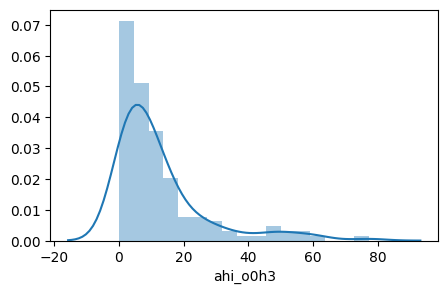

In [12]:
plt.figure(figsize=(5, 3))
sns.distplot(y, kde=True)
plt.grid(False)
plt.show(block=False)

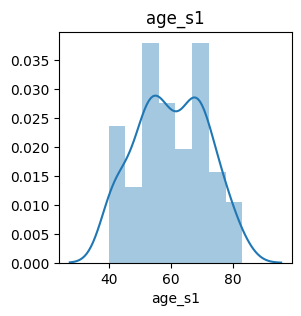

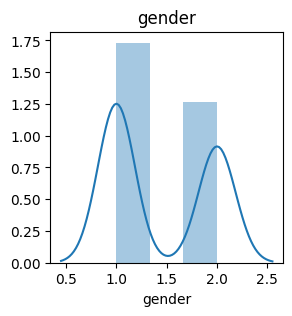

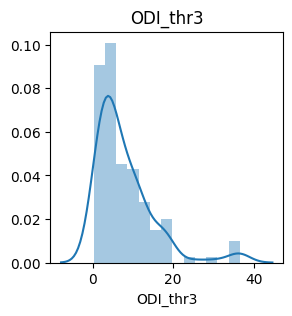

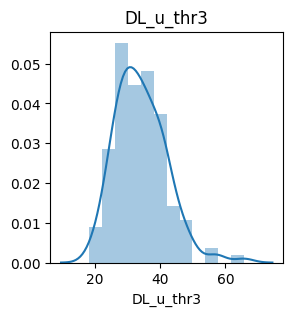

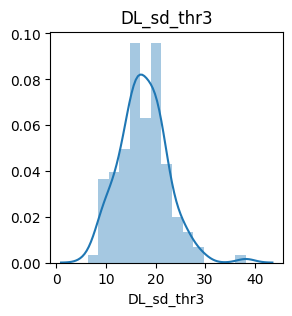

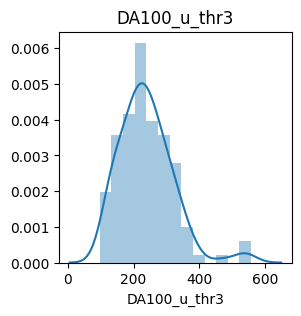

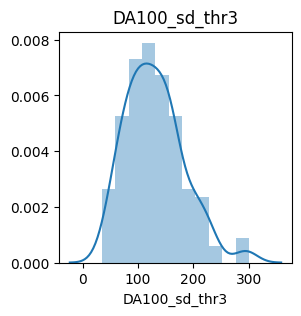

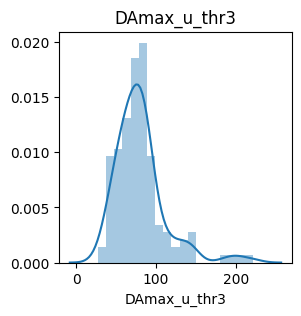

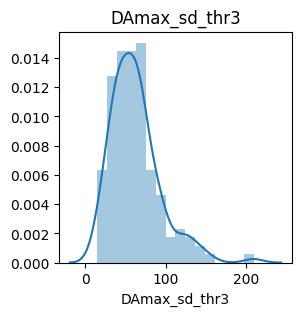

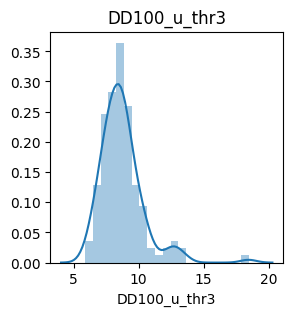

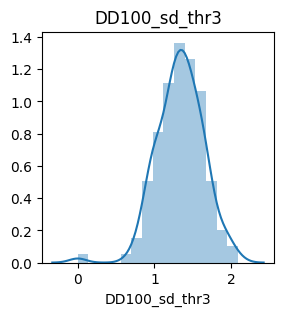

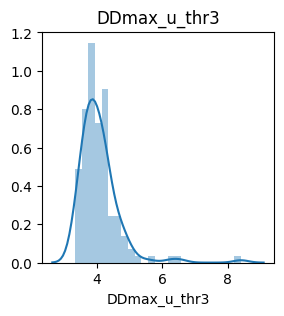

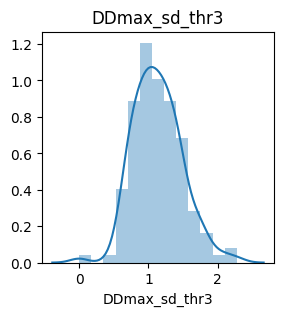

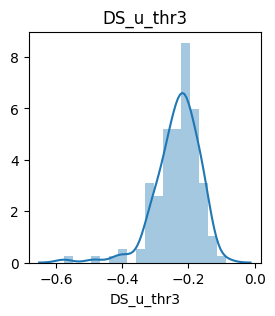

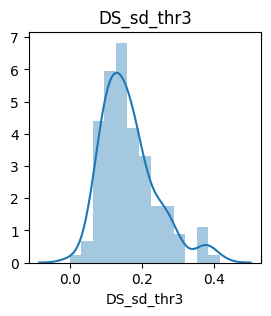

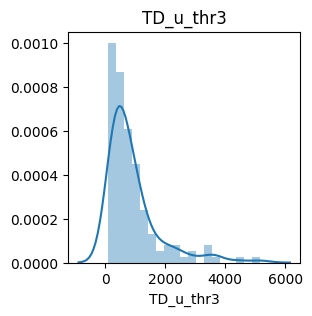

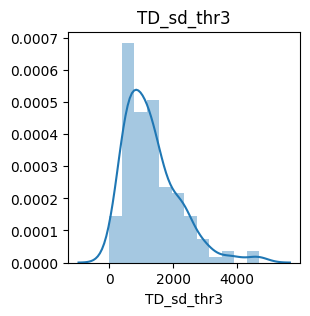

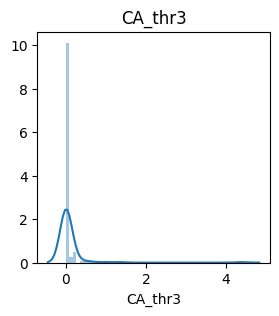

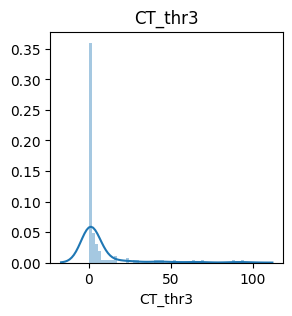

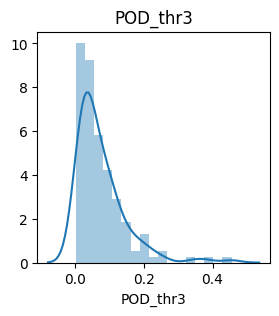

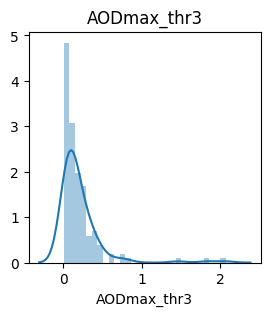

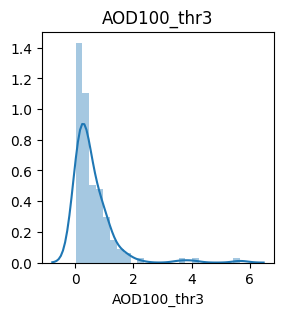

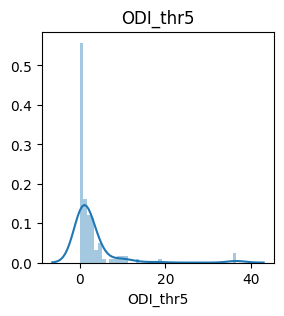

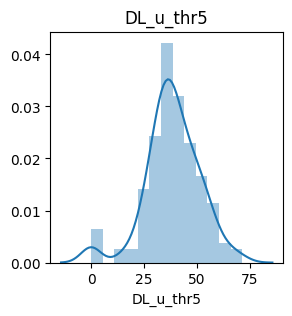

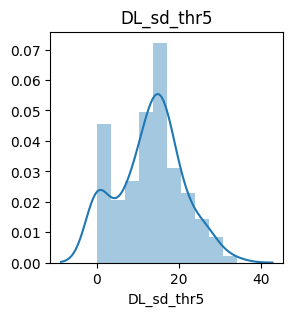

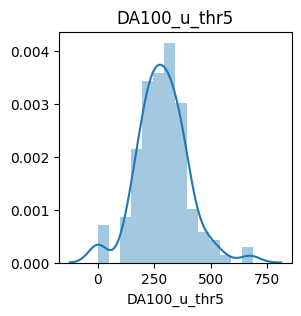

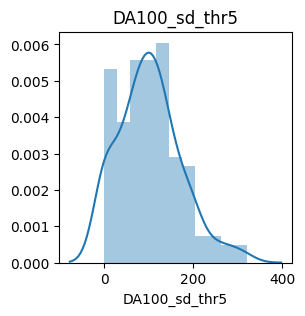

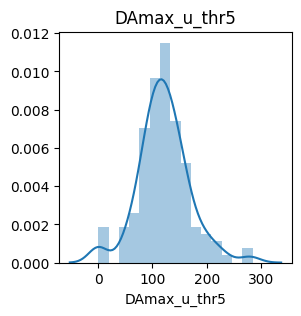

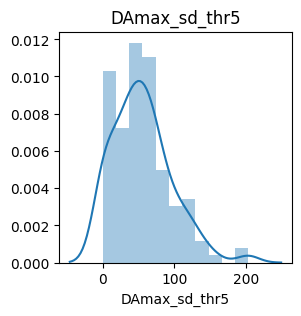

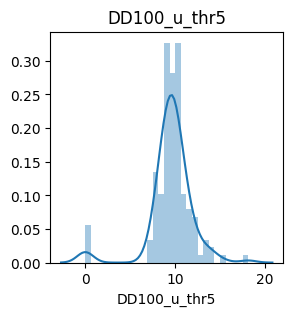

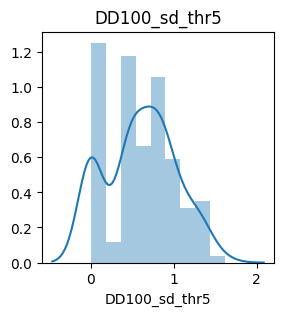

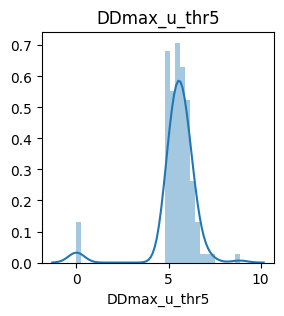

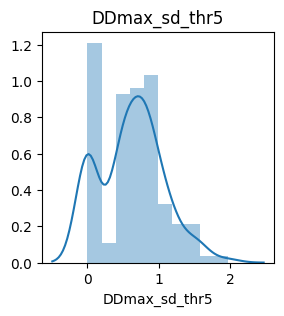

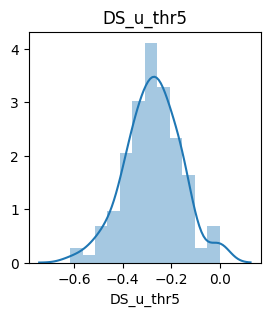

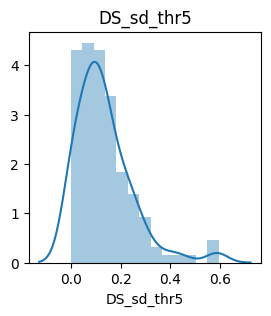

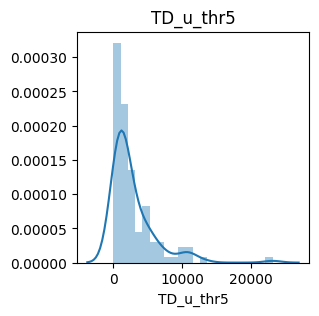

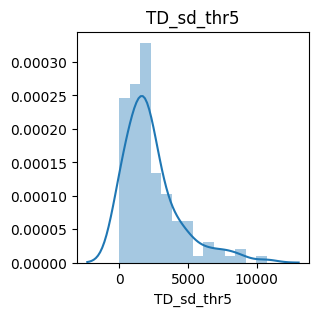

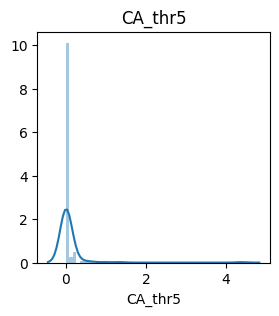

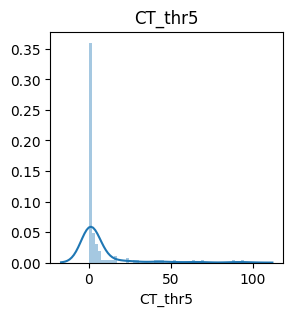

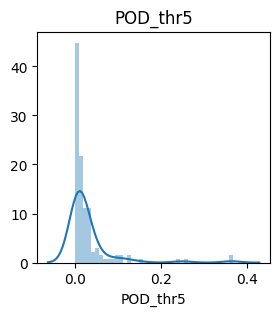

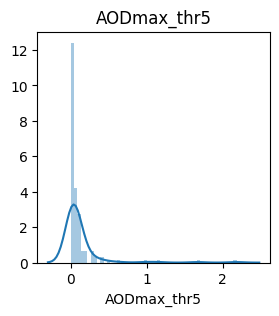

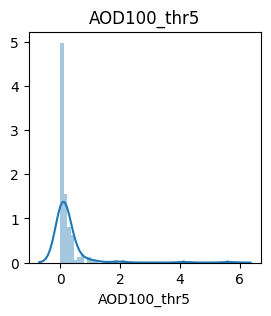

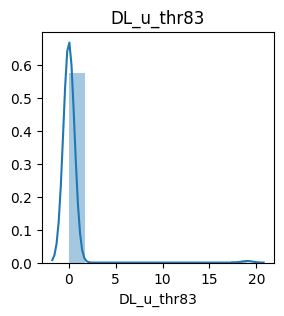

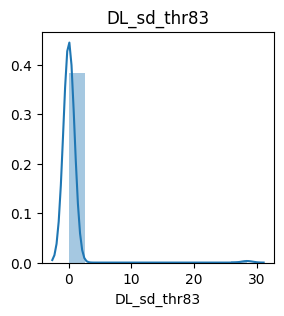

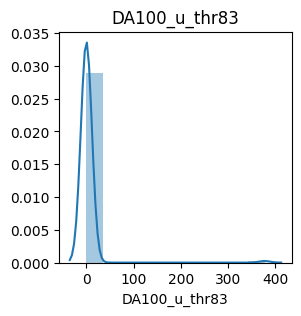

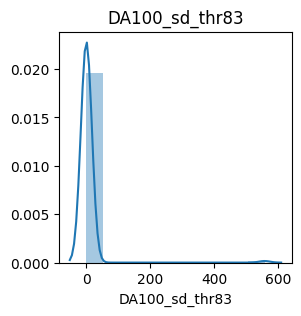

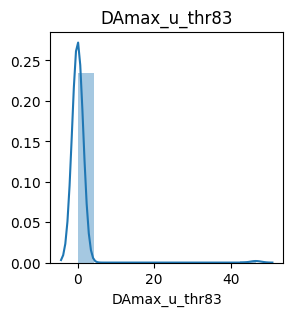

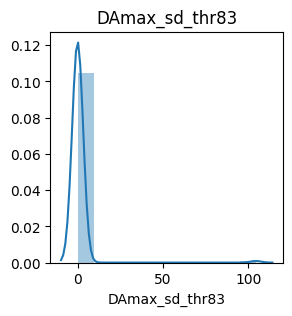

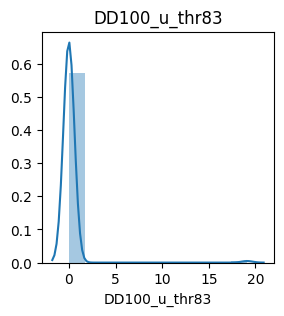

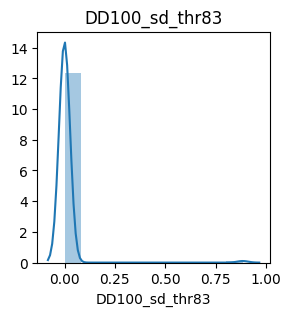

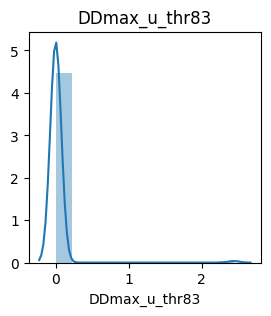

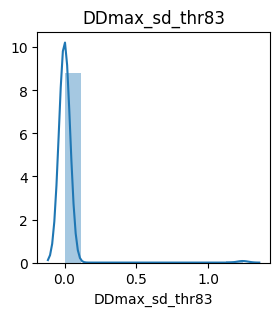

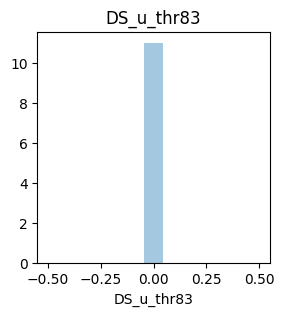

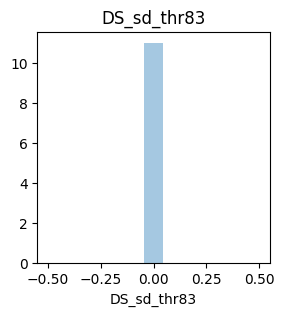

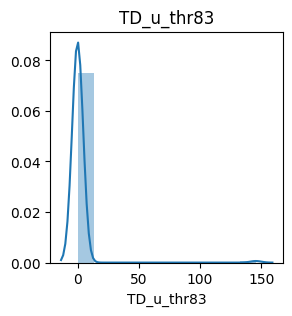

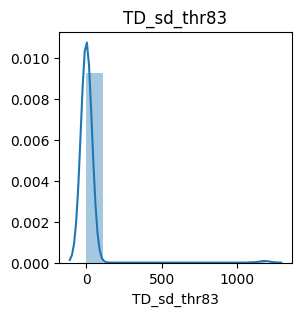

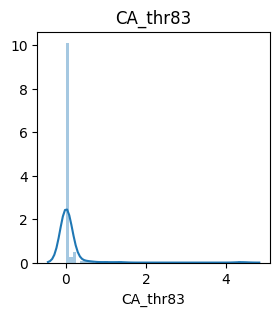

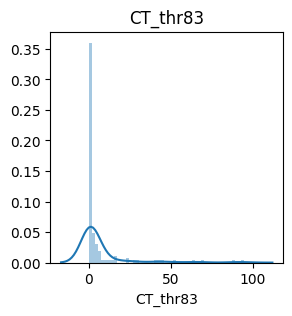

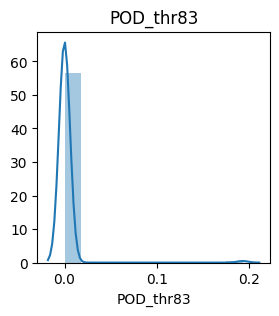

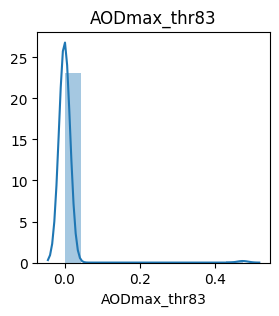

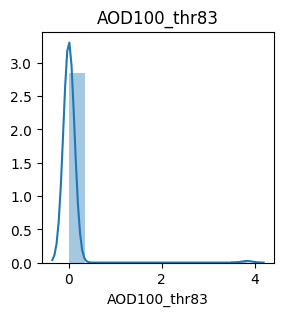

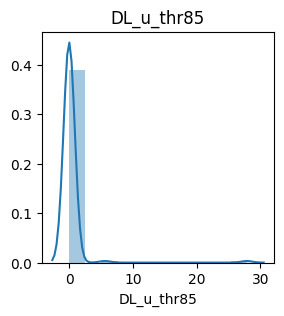

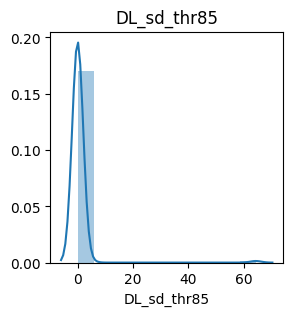

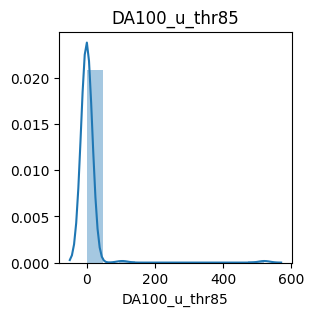

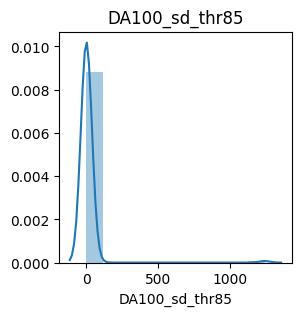

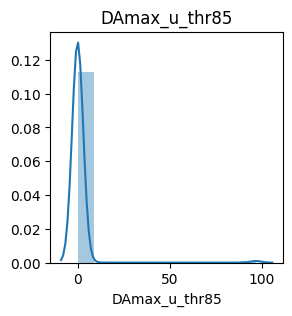

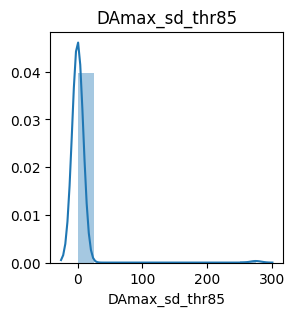

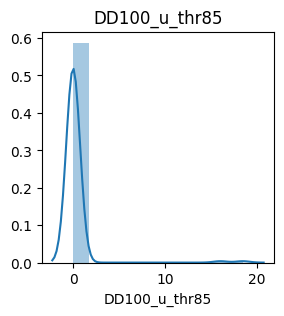

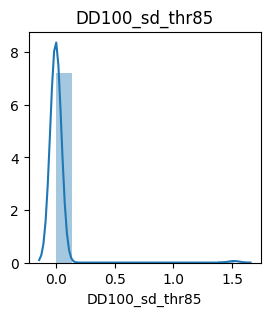

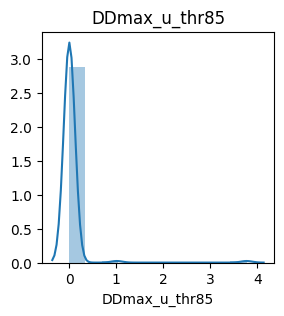

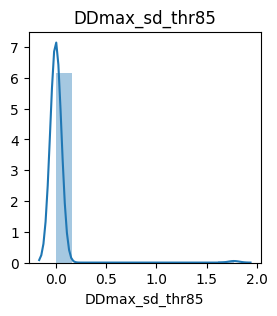

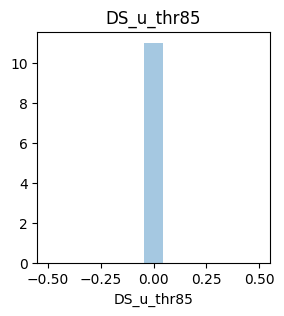

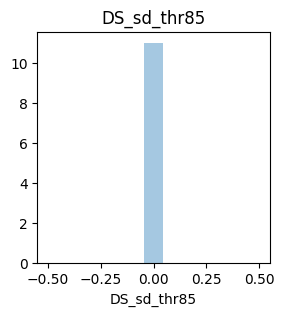

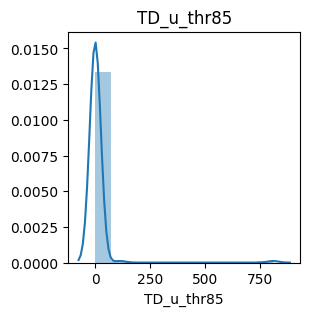

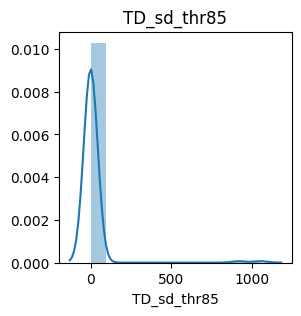

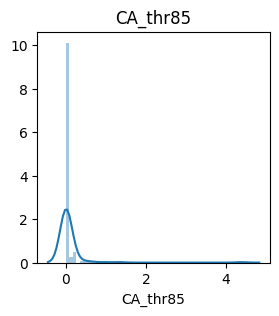

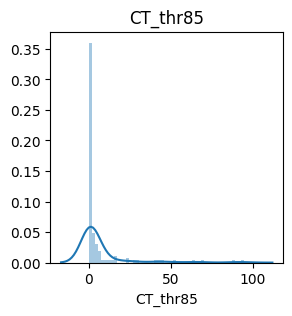

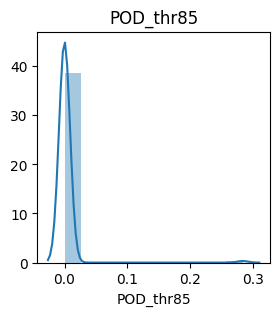

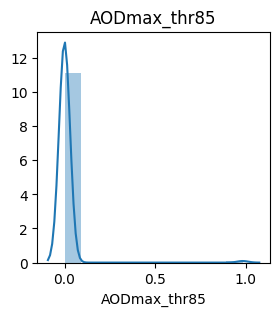

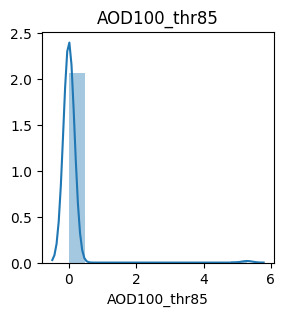

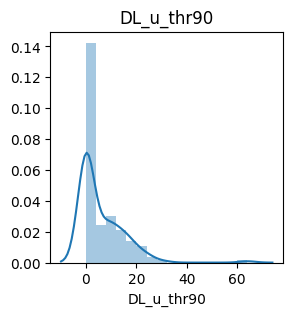

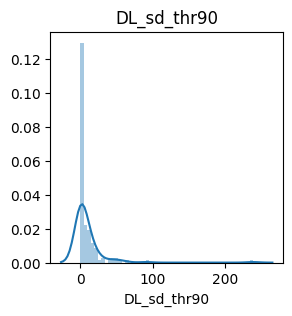

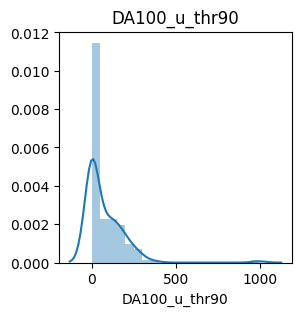

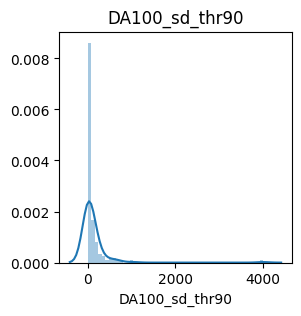

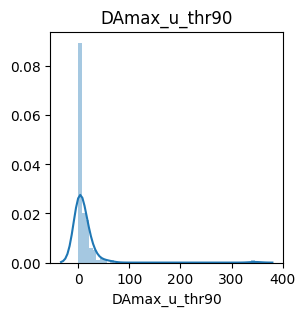

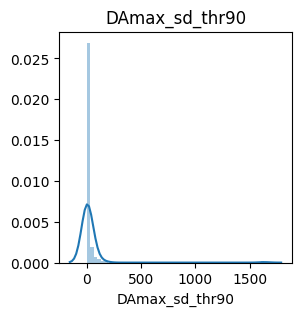

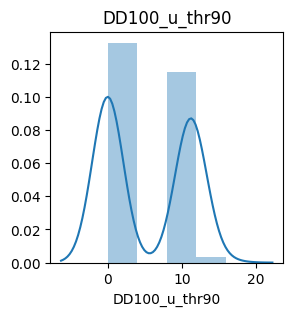

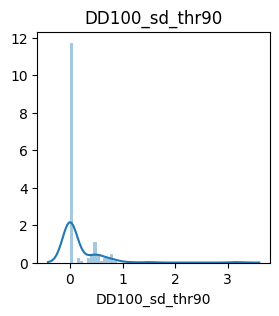

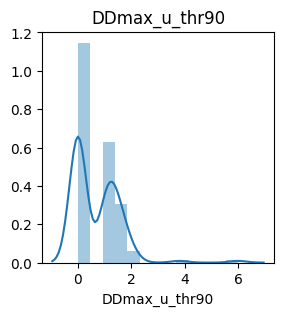

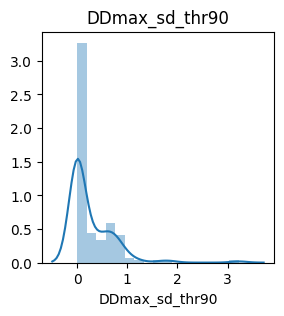

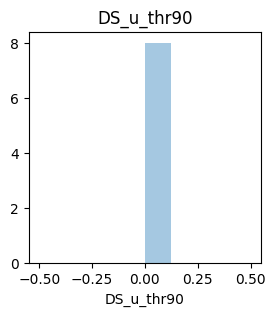

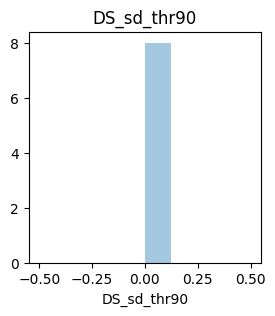

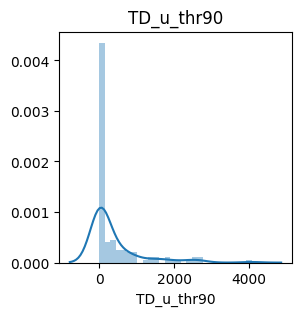

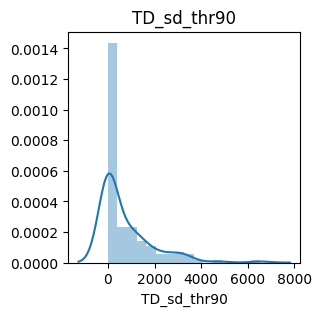

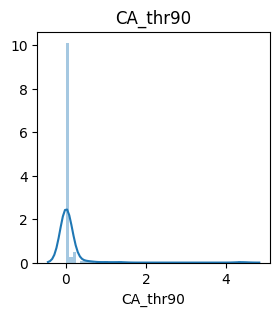

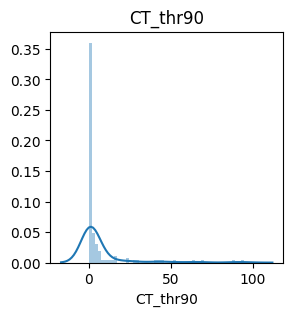

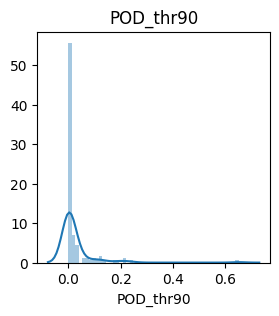

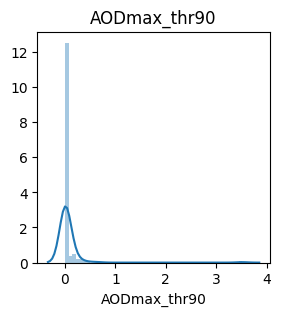

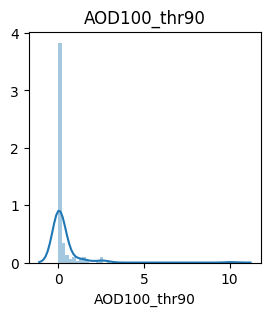

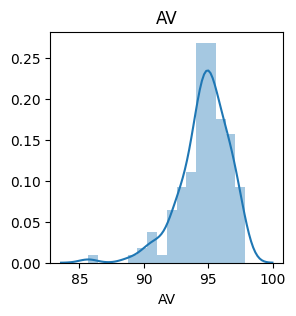

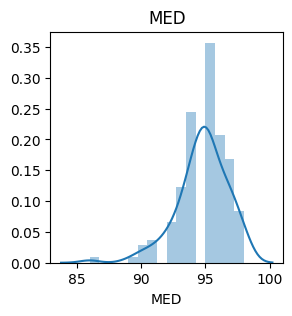

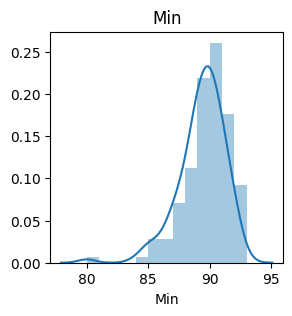

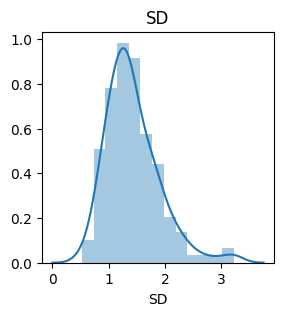

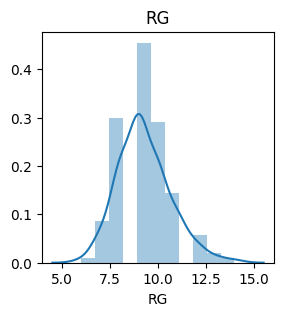

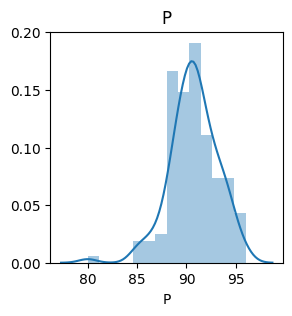

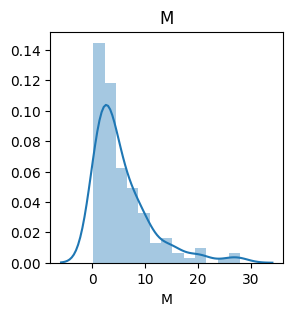

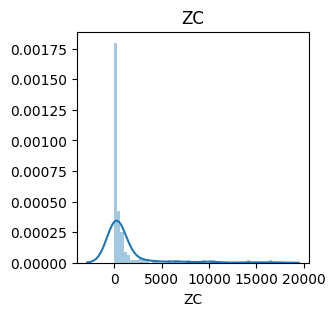

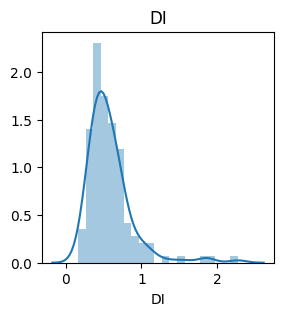

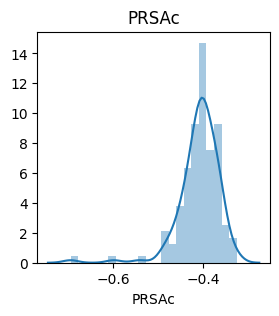

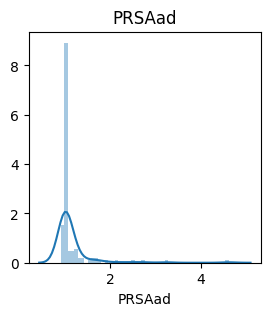

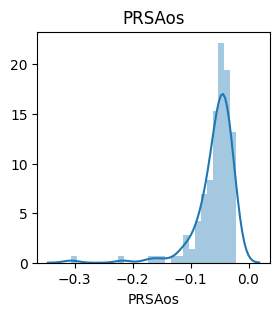

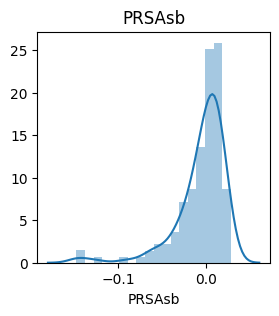

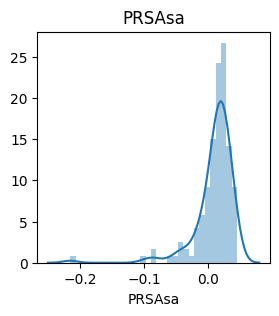

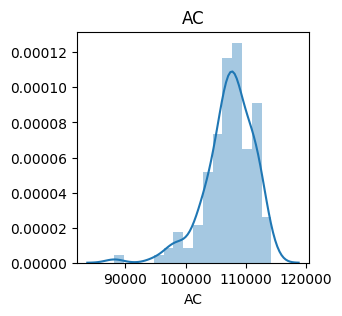

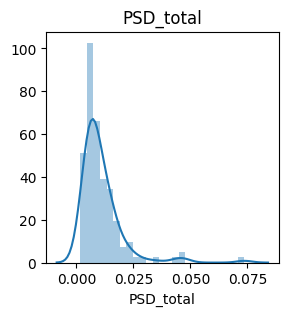

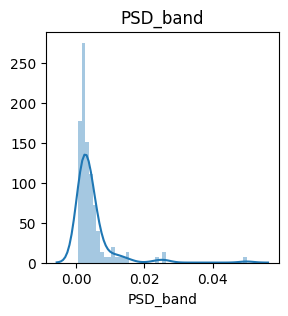

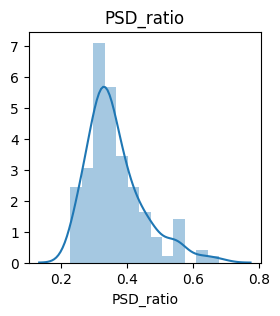

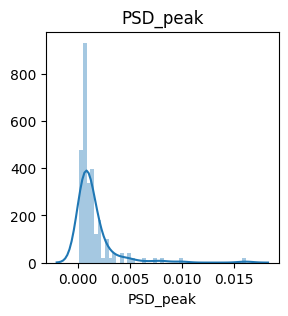

In [13]:
for col in X.columns:
    plt.figure(figsize=(3,3))
    plt.title(f"{col}")
    sns.distplot(X[col], kde=True)
    plt.show(block=False)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(113, 118) (113,) (29, 118) (29,)


In [15]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, y_train.shape, X_train_scaled.shape, y_test.shape)

(113, 118) (113,) (113, 118) (29,)


In [17]:
# def plot_cm(cm):
#     plt.figure(figsize=(2.5,2))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()

In [18]:
# from sklearn.metrics import accuracy_score

# def compute_folds(X, y, folds):
#     if folds > len(X):
#         raise ValueError(f"{folds} > {len(X)} IMPOSSIBLE")
    
#     X_folds = np.array_split(X, folds)
#     y_folds = np.array_split(y, folds)

#     print(f"Number of folds: {folds}")
#     return X_folds, y_folds

# def cross_validation(model_class, X, y, folds):
#     X_folds, y_folds = compute_folds(X, y, folds)
#     acc_scores = []

#     for i in range(folds):
#         # Create training data by excluding fold i
#         X_train = np.vstack(X_folds[:i] + X_folds[i+1:])
#         y_train = np.hstack(y_folds[:i] + y_folds[i+1:])

#         # Validation data = fold i
#         X_val = X_folds[i]
#         y_val = y_folds[i]

#         # Reinitialize model to avoid accumulation across folds
#         model = model_class()

#         # Train and predict
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         acc = accuracy_score(y_val, y_pred)
#         acc_scores.append(acc)
#         print(f"Fold {i} Accuracy: {acc:.4f}")

#     print(f"\nAverage Accuracy: {np.mean(acc_scores):.4f}")

In [19]:
def plot_rg(true, pred):
    max_ = max(true.max(), pred.max())
    plt.figure(figsize=(5,5))
    plt.plot([0, max_], [0, max_], 'r--')
    sns.scatterplot(true, pred, alpha=0.7)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

def compute_folds(X, y, folds):
    if folds > len(X):
        raise ValueError(f"{folds} > {len(X)} IMPOSSIBLE")
    
    X_folds = np.array_split(X, folds)
    y_folds = np.array_split(y, folds)

    print(f"Number of folds: {folds}")
    return X_folds, y_folds

def cross_validation(model_class, X, y, folds):
    X_folds, y_folds = compute_folds(X, y, folds)
    acc_scores = []

    for i in range(folds):
        # Create training data by excluding fold i
        X_train = np.vstack(X_folds[:i] + X_folds[i+1:])
        y_train = np.hstack(y_folds[:i] + y_folds[i+1:])

        # Validation data = fold i
        X_val = X_folds[i]
        y_val = y_folds[i]

        # Reinitialize model to avoid accumulation across folds
        model = model_class()

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = mean_squared_error(y_val, y_pred)
        acc_scores.append(acc)
        print(f"Fold {i} rmse: {acc:.4f}")

    print(f"\nAverage rmse: {np.mean(acc_scores):.4f}")

In [21]:
from sklearn.linear_model import LinearRegression

log_model = LinearRegression()
log_model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
from sklearn.metrics import mean_squared_error

y_pred = log_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))


373.5469713432994


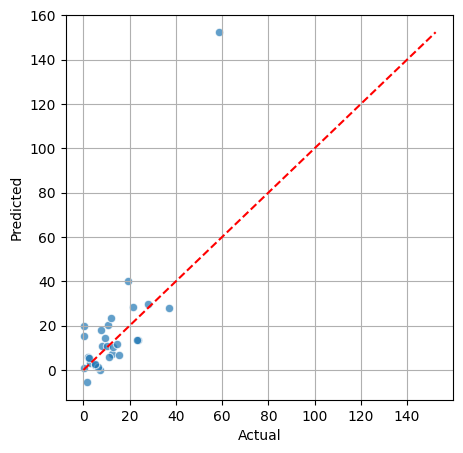

In [23]:
plot_rg(y_test, y_pred)

In [24]:
cross_validation(LinearRegression, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 53.3158
Fold 1 rmse: 109.4947
Fold 2 rmse: 12233.5122
Fold 3 rmse: 298.3285
Fold 4 rmse: 91.6843
Fold 5 rmse: 27.2472
Fold 6 rmse: 71.4248
Fold 7 rmse: 240.7695
Fold 8 rmse: 60.3349
Fold 9 rmse: 2343.5065

Average rmse: 1552.9618


In [25]:
from sklearn.tree import DecisionTreeRegressor

dtree_model = DecisionTreeRegressor()
dtree_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [26]:
y_pred = dtree_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

73.11580524208574


In [27]:
cross_validation(DecisionTreeRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 42.7154
Fold 1 rmse: 88.7051
Fold 2 rmse: 90.0160
Fold 3 rmse: 85.7204
Fold 4 rmse: 139.0630
Fold 5 rmse: 15.6496
Fold 6 rmse: 65.3396
Fold 7 rmse: 202.1291
Fold 8 rmse: 90.7530
Fold 9 rmse: 235.6759

Average rmse: 105.5767


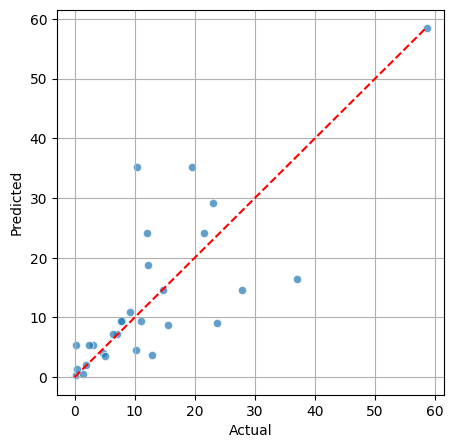

In [28]:
plot_rg(y_test, y_pred)

In [29]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squarederror', ...)

In [30]:
y_pred = xgb_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

51.21274030330073


In [31]:
cross_validation(XGBRegressor, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 rmse: 52.5886
Fold 1 rmse: 55.2350
Fold 2 rmse: 58.4654
Fold 3 rmse: 82.4169
Fold 4 rmse: 52.9738
Fold 5 rmse: 25.0753
Fold 6 rmse: 36.6082
Fold 7 rmse: 35.9039
Fold 8 rmse: 22.2785
Fold 9 rmse: 60.0476

Average rmse: 48.1593


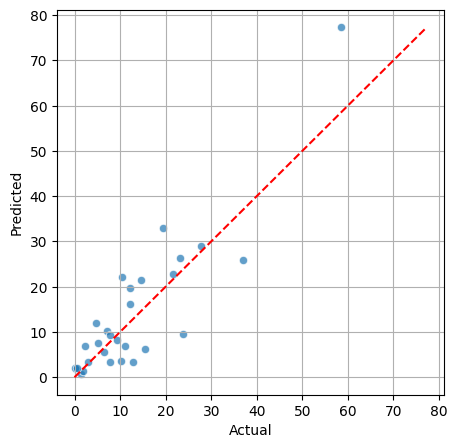

In [32]:
plot_rg(y_test, y_pred)

In [33]:
from xgboost import XGBRFRegressor

xgb_model = XGBRFRegressor()
xgb_model.fit(X_train_scaled, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=0.8,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1.0, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [34]:
y_pred = xgb_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

45.81938926917812


In [35]:
y_pred = xgb_model.predict(X_test_scaled)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

45.81938926917812


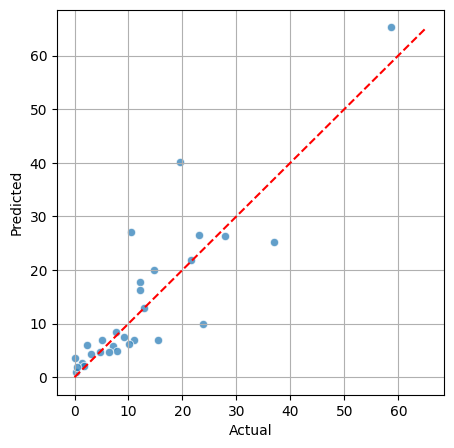

In [36]:
plot_rg(y_test, y_pred)